In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai import *
from fastai.vision import *

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

seed = 12345

/content/drive/My Drive/alfalfa-convnets


In [3]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


# Train

In [7]:
%run -i "/content/drive/My Drive/alfalfa-convnets/src/train_alfalfa.py"  \
    --catalog=fgas \
    --model=mxresnet34 --val-pct=0.2 \
    --lr=10e-2 --bs=64 --n_epochs=1 \
    --precision=full --seed=12345 \
    # --save="best_a40A-34_lr{lr}_bs{bs}_nepoch{n_epoch}"

set state called


KeyboardInterrupt: ignored

In [10]:
learn.load('best_a40A-34_lr{lr}_bs{bs}_nepoch{n_epoch}');

set state called


The best model is saved in `{PATH}/models/best_a40.pth`, unless another filename has been specified.

## Experimental results
    
    Results (all_properties = False; 7399)
 
      n_epoch  max_lr  arch  bs    Val loss  TTA loss    time (h:mm)
         40    10e-2    34   64      0.342     0.350     1:02
     
                              Val loss    TTA loss
      n_epoch  max_lr  precision   arch    --------    --------
        100     3e-2     mixed      34       0.240       0.246 
        100     3e-2     full       34       0.242       0.250
         40     3e-2     full       34       0.241       0.248
         
        100     3e-2     full       50       0.242       0.248
        
        
    Results (all_properties = True; 4797)
    
         40     5e-2     full       34       0.241       0.249
         40     3e-2     full       34       0.239       0.245
         40     1e-2     full       34       0.242       0.250
         40     3e-2     full       50       0.240       0.246

        

Note: mixed precision is great on NVidia T4 cards (available on Colab), but it's actually slower than 32-bit floats when using P100s!


    Training + validation time per epoch (`fgas` catalog)
    
                       P100 `fgas` `all`
                       ==== ------ -----
    Mixed precision          0:51   0:31
    Full precision           0:50   0:29

# Evaluate

In [0]:
learn.to_fp32();

In [11]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2952)

# Plot

In [0]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)


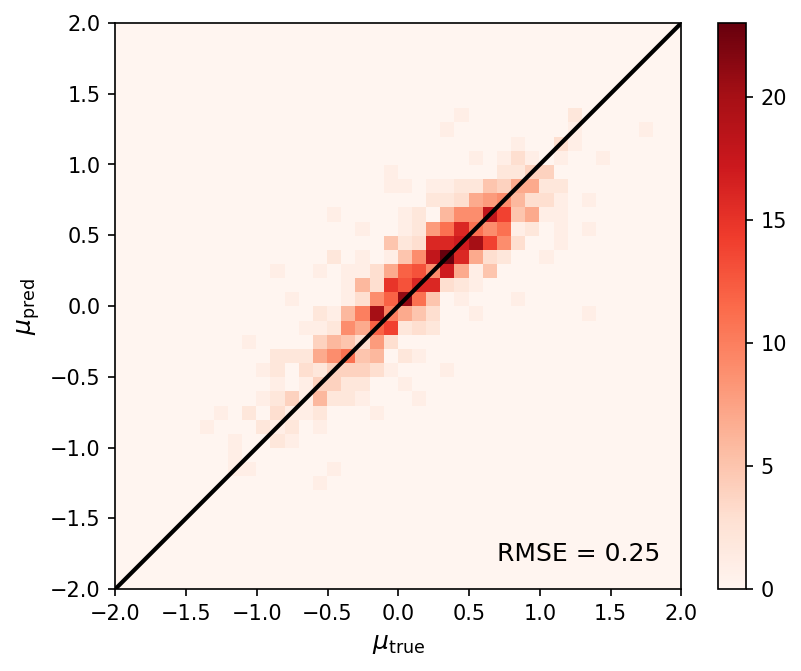

In [0]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(results.fgas_true, results.fgas_pred, cmap='Reds', range=[(-2, 2), (-2, 2)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)
plt.gca().set_aspect('equal')
plt.colorbar();
plt.xlabel(r'$\mu_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mu_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2.5, .5))
plt.yticks(np.arange(-2, 2.5, .5));

plt.text(0.7, -1.8, f'RMSE = {root_mean_squared_error(fgas_pred, fgas_true):.2f}', fontsize=12);

# terrible terrible way to determine which catalog we're using
catalog_id = "B" if len(df) == 4797 else "A"
plt.savefig(f'{PATH}/results/figures/results-hist_a40{catalog_id}')